# Capstone: West Nile Virus
## Challenge
 
West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

Given weather, location, testing, and spraying data, we are asked to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns',1000)

from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTENC, ADASYN

##### Training and Test data:
The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set we are requested 
to predict the test results for 2008, 2010, 2012, and 2014.

In [23]:
train = pd.read_csv('./datasets/train.csv')

# Make Date into datetime object, and index:
train['Date'] = pd.to_datetime(train.Date, format='%Y-%m-%d')
train.set_index('Date', inplace=True, drop=True)
train.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


We make a note here of the baseline to be bettered through modelling:

In [24]:
print('Baseline = {}'.format(train.WnvPresent.value_counts(normalize=True).max()))
train.WnvPresent.value_counts()

# we can see clearly the problem: only 5% of those traps inspected carried Wnv, can we improve on this?
# we also see a class imbalance here that will need to be resolved before modelling

Baseline = 0.9475537787930707


0    9955
1     551
Name: WnvPresent, dtype: int64

In [25]:
test = pd.read_csv('./datasets/test.csv')
# Make Date into datetime object, and index
test['Date'] = pd.to_datetime(test.Date, format='%Y-%m-%d')
test.set_index('Date', inplace=True, drop=True)
test.head(1)

,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
Date,,,,,,,,,,
2008-06-11,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


##### Weather Data:
It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. 
We are provided with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of
the tests. 
    Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
    Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [26]:
weather = pd.read_csv('./datasets/weather.csv')
# Make Date into datetime object, and index
weather['Date'] = pd.to_datetime(weather.Date, format='%Y-%m-%d')
weather.set_index('Date', inplace=True, drop=True)

# Data Cleaning:
weather['Tavg'] = pd.to_numeric(weather.apply(lambda x: (x['Tmin']+x['Tmax'])/2, axis=1))
weather['PrecipTotal'] = pd.to_numeric(weather.apply(lambda x: 0 if x['PrecipTotal']=='  T' or x['PrecipTotal']=='M' else x['PrecipTotal'], axis=1))

# Add Long / Lat:
weather.insert(1,'Latitude', weather.apply(lambda x: 41.995 if x['Station']==1 else 41.786, axis=1))
weather.insert(2,'Longitude', weather.apply(lambda x: -87.933 if x['Station']==1 else -87.752, axis=1))

weather.head(1)

,Station,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2


In [27]:
# save to csv for import into Tableau
weather.to_csv(r'./datasets/weather_map.csv')

##### Spray Data

The City of Chicago also does spraying to kill mosquitos. We are given the GIS data for their spray efforts
in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus.

In [28]:
spray = pd.read_csv('./datasets/spray.csv')
# Make Date into datetime object, and index
spray['Date'] = pd.to_datetime(spray.Date, format='%Y-%m-%d')
spray.set_index('Date', inplace=True, drop=True)
spray.drop(columns='Time', inplace=True)
spray.head(1)

,Latitude,Longitude
Date,,
2011-08-29,42.391623,-88.089163


## EDA

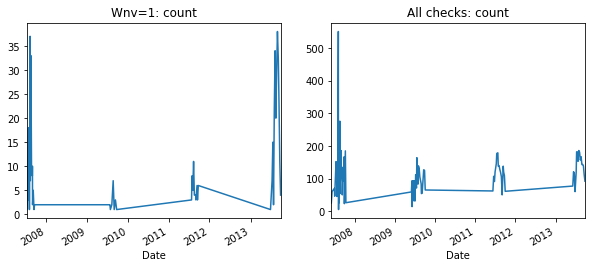

In [29]:
# strong seasonal effects according to WnvPresent timeline of incidence, summer = more Wnv:
# interestingly 2007 and 2013 had far higher incidences than the intervening years.
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
train[train['WnvPresent']==1]['WnvPresent'].groupby('Date').count().plot(ax=ax[0], title='Wnv=1: count')
train['WnvPresent'].groupby('Date').count().plot(ax=ax[1], title='All checks: count');

# comparing this plot to the one above, we see there were fewer tests overall in the intervening years, and more
# tests in 2013 coupled with higher rate of positives, why?
    # Was Chicago starting to predict better the WNV's whereabouts?
    # Did weather mean there were more mosquitos and therefore more WNV in 2007 and 2013 vs. other times?

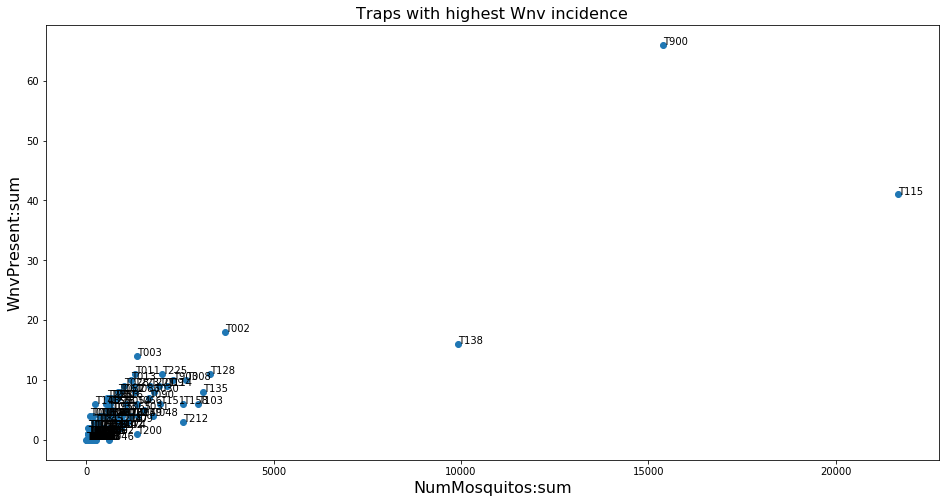

In [101]:
# Which Traps had the highest incidence of Wnv and NumMosquitos?

train_grp = train.groupby('Trap').agg({'WnvPresent':'sum',
                                       'NumMosquitos': 'sum'}).sort_values('WnvPresent', ascending=False)

fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(train_grp['NumMosquitos'], train_grp['WnvPresent']);
for i, xi in enumerate(train_grp.index):
    ax.annotate(xi, (train_grp.iloc[i,1], train_grp.iloc[i,0]))
ax.set_xlabel('NumMosquitos:sum', fontsize=16)
ax.set_ylabel('WnvPresent:sum', fontsize=16)
ax.set_title('Traps with highest Wnv incidence', fontsize=16)
plt.show();

# it seems there were a handful of Traps that had the highest WnvPresent and NumMosquitos

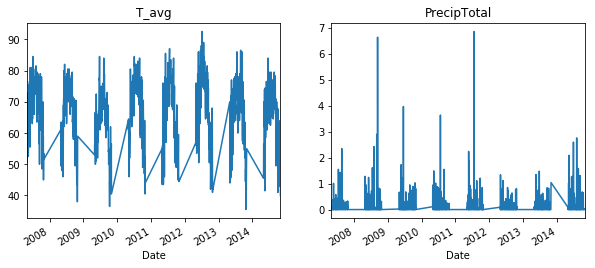

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
pd.to_numeric(weather[(weather['Station']==1)].Tavg).plot(ax=ax[0], title='T_avg')
pd.to_numeric(weather[(weather['Station']==1)].PrecipTotal).plot(ax=ax[1], title='PrecipTotal');

# Tavg is pretty steady across the time period, but interestingly precipitation was higher in those years that
# fewer cases of Wnv were found, perhaps an explainer?
    # We will add these two columns to train data:

In [31]:
train.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [32]:
# Reformatting weather data into flattened version for merging with train data, and selecting only
# relevant data:

# weather_station_1 = weather[weather['Station']==1][['Latitude','Longitude','Tavg','PrecipTotal']]
# weather_station_2 = weather[weather['Station']==2][['Latitude','Longitude','Tavg','PrecipTotal']]

weather_station_1 = weather[weather['Station']==1]
weather_station_2 = weather[weather['Station']==2]

weather_df = weather_station_1.merge(weather_station_2,
                                     how='inner',
                                     on='Date',
                                     suffixes=('_station_1','_station_2'))
weather_df.head(1)

,Station_station_1,Latitude_station_1,Longitude_station_1,Tmax_station_1,Tmin_station_1,Tavg_station_1,Depart_station_1,DewPoint_station_1,WetBulb_station_1,Heat_station_1,Cool_station_1,Sunrise_station_1,Sunset_station_1,CodeSum_station_1,Depth_station_1,Water1_station_1,SnowFall_station_1,PrecipTotal_station_1,StnPressure_station_1,SeaLevel_station_1,ResultSpeed_station_1,ResultDir_station_1,AvgSpeed_station_1,Station_station_2,Latitude_station_2,Longitude_station_2,Tmax_station_2,Tmin_station_2,Tavg_station_2,Depart_station_2,DewPoint_station_2,WetBulb_station_2,Heat_station_2,Cool_station_2,Sunrise_station_2,Sunset_station_2,CodeSum_station_2,Depth_station_2,Water1_station_2,SnowFall_station_2,PrecipTotal_station_2,StnPressure_station_2,SeaLevel_station_2,ResultSpeed_station_2,ResultDir_station_2,AvgSpeed_station_2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2,2,41.786,-87.752,84,52,68.0,M,51,57,0,3,-,-,,M,M,M,0.0,29.18,29.82,2.7,25,9.6


In [33]:
# Merging weather data onto train data:
train_df = train.merge(weather_df, how='left', on='Date', suffixes=('',''))
train_df.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station_station_1,Latitude_station_1,Longitude_station_1,Tmax_station_1,Tmin_station_1,Tavg_station_1,Depart_station_1,DewPoint_station_1,WetBulb_station_1,Heat_station_1,Cool_station_1,Sunrise_station_1,Sunset_station_1,CodeSum_station_1,Depth_station_1,Water1_station_1,SnowFall_station_1,PrecipTotal_station_1,StnPressure_station_1,SeaLevel_station_1,ResultSpeed_station_1,ResultDir_station_1,AvgSpeed_station_1,Station_station_2,Latitude_station_2,Longitude_station_2,Tmax_station_2,Tmin_station_2,Tavg_station_2,Depart_station_2,DewPoint_station_2,WetBulb_station_2,Heat_station_2,Cool_station_2,Sunrise_station_2,Sunset_station_2,CodeSum_station_2,Depth_station_2,Water1_station_2,SnowFall_station_2,PrecipTotal_station_2,StnPressure_station_2,SeaLevel_station_2,ResultSpeed_station_2,ResultDir_station_2,AvgSpeed_station_2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,1,41.995,-87.933,88,60,74.0,10,58,65,0,9,0421,1917,BR HZ,0,M,0.0,0.0,29.39,30.11,5.8,18,6.5,2,41.786,-87.752,88,65,76.5,M,59,66,0,12,-,-,BR HZ,M,M,M,0.0,29.44,30.09,5.8,16,7.4


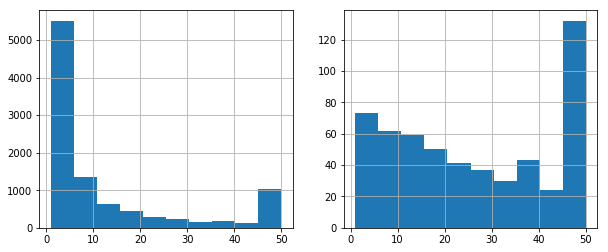

In [34]:
# Plotting histograms for NumMosquitos for each of Wnv=0 and Wnv=1 cases illustrates NumMosquitos
# could be a predictor of Wnv if we deal with the class imbalance:
fig, ax = plt.subplots(figsize=(10,4), ncols=2)
train_df[train_df['WnvPresent']==0]['NumMosquitos'].hist(ax=ax[0])
train_df[train_df['WnvPresent']==1]['NumMosquitos'].hist(ax=ax[1]);

In [41]:
y, X = train_df['WnvPresent'], train_df[['NumMosquitos','Tavg_station_1','PrecipTotal_station_1']]

# ADASYN to deal with class imbalance:
ad = ADASYN()
X, y = ad.fit_sample(X, y)

print('Resampled baseline = {}'.format(y.value_counts(normalize=True).max()))

scaler = StandardScaler()
Xs = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

models = [BaggingClassifier(n_estimators=100),
          RandomForestClassifier(n_estimators=100),
          GradientBoostingClassifier(n_estimators=100,
                                     random_state=1,
                                     validation_fraction=0.1,
                                     max_depth=3,
                                     n_iter_no_change=20)]
params = [{'max_features': np.linspace(0.3,0.4,3)},
          {'max_depth': list(range(2,20,5)),
           'min_samples_split': np.linspace(0.3,0.4,3)},
          {'learning_rate': np.linspace(.1,1.,4)}]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for i in range(len(models)):
    gs = GridSearchCV(models[i], params[i], n_jobs=2, cv=kf, verbose=1)
    gs.fit(Xs[['Tavg_station_1','PrecipTotal_station_1']], y)
    print('Best params:',gs.best_params_)
    print('Cross Val Score:',gs.best_score_)
    predictions = gs.predict(Xs[['Tavg_station_1','PrecipTotal_station_1']])
    print('Confusion Matrix:')
    print(' ')
    print(confusion_matrix(y, predictions, labels=[0,1]))
    print('Classification Report:')
    print(' ')
    print(classification_report(y, predictions))

Resampled baseline = 0.5004014854963365
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   13.5s finished


Best params: {'max_features': 0.4}
Cross Val Score: 0.8159692675934151
Confusion Matrix:
 
[[8929 1026]
 [2594 7377]]
Classification Report:
 
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      9955
           1       0.88      0.74      0.80      9971

    accuracy                           0.82     19926
   macro avg       0.83      0.82      0.82     19926
weighted avg       0.83      0.82      0.82     19926

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   18.3s finished


Best params: {'max_depth': 7, 'min_samples_split': 0.3}
Cross Val Score: 0.6717363721582629
Confusion Matrix:
 
[[4686 5269]
 [1531 8440]]
Classification Report:
 
              precision    recall  f1-score   support

           0       0.75      0.47      0.58      9955
           1       0.62      0.85      0.71      9971

    accuracy                           0.66     19926
   macro avg       0.68      0.66      0.65     19926
weighted avg       0.68      0.66      0.65     19926

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    8.6s finished


Best params: {'learning_rate': 0.7}
Cross Val Score: 0.8239487264396528
Confusion Matrix:
 
[[8397 1558]
 [1859 8112]]
Classification Report:
 
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      9955
           1       0.84      0.81      0.83      9971

    accuracy                           0.83     19926
   macro avg       0.83      0.83      0.83     19926
weighted avg       0.83      0.83      0.83     19926



In [42]:
# For the best estimator, inspect the feature importances:
if 'BaggingClassifier' in gs.best_estimator_:
    feature_importances = pd.DataFrame({'importance':np.mean([tree.feature_importances_ for tree in gs.estimators_], axis=0)},
                                                 index=['Tavg_station_1','PrecipTotal_station_1'])
else:
    feature_importances = pd.DataFrame({'importance':gs.best_estimator_.feature_importances_},
                                                 index=['Tavg_station_1','PrecipTotal_station_1'])
    
feature_importances.sort_values('importance',ascending=False).T

,Tavg_station_1,PrecipTotal_station_1
importance,0.68119,0.31881


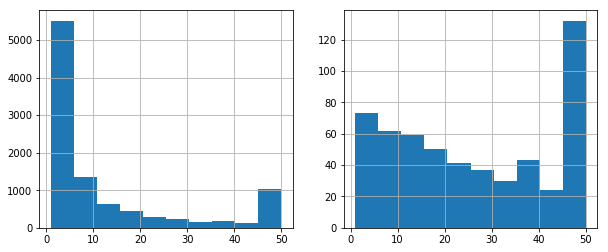

In [43]:
# We can re-plot histograms and see that the relative distribution of bins is the same in both classes, but
# the potential for NumMosquitos as a predictor is made clearer:

plot_df = train_df[['WnvPresent','NumMosquitos']]
plot_df.head()

fig, ax = plt.subplots(figsize=(10,4), ncols=2)
plot_df[plot_df['WnvPresent']==0]['NumMosquitos'].hist(ax=ax[0])
plot_df[plot_df['WnvPresent']==1]['NumMosquitos'].hist(ax=ax[1]);

In [44]:
# let's look into modelling for high levels of NumMosquitos, ie. is it driven by weather?

y, X = train_df['NumMosquitos'], train_df[['Tavg_station_1','PrecipTotal_station_1',
                                           'Tavg_station_2','PrecipTotal_station_2']]

# ADASYN to deal with class imbalance:
ad = ADASYN()
X, y = ad.fit_sample(X, y)

elastic = ElasticNetCV(l1_ratio=np.linspace(0.1,1.0),
                       alphas=np.logspace(-4, 4, 10), cv=kf, max_iter=10000)
elastic.fit(X, y)
print(elastic.alpha_)
print(elastic.l1_ratio_)
print('ElasticNet CV score:', cross_val_score(elastic, X, y, cv=kf).mean())

# Tavg and PrecipTotal on their own poor predictors for NumMosquitos

0.0001
0.9816326530612246
ElasticNet CV score: 0.0315732728352867


In [ ]:
# To do:
    # fix tableau plot to sum of WnvPresent
    # discuss prelim results with Christophe (ie. airports and rivers, and spray in summer)
    # redo model for the submission: perhaps segregate by month as this is the best indicator of when
    # and add Trap to model which will require SMOTE with categorical variables.
    # see how well that performs?
    # then experiment with XGBoost

In [102]:
test.head(1)

,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
Date,,,,,,,,,,
2008-06-11,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
